In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip -O /content/cassavaleafdata.zip

--2024-12-09 03:28:53--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.207, 74.125.139.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/octet-stream]
Saving to: ‘/content/cassavaleafdata.zip’

/content/cassavalea 100%[===================>]   1.26G  50.3MB/s    in 17s     

2024-12-09 03:29:10 (78.2 MB/s) - ‘/content/cassavaleafdata.zip’ saved [1354096203/1354096203]



In [ ]:
!unzip /content/cassavaleafdata.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
 

In [ ]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

#### **1. Data Preprocessing**

In [ ]:
data_paths = {
    'train': './cassavaleafdata/train',
    'valid': './cassavaleafdata/validation',
    'test': './cassavaleafdata/test'
}

# Load image from path
def loader(path):
    return Image.open(path)

img_size = 150
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root=data_paths['train'],
                                  transform=train_transform,
                                  loader=loader)

valid_data = datasets.ImageFolder(root=data_paths['valid'],
                                  transform=train_transform)

test_data = datasets.ImageFolder(root=data_paths['test'],
                                 transform=train_transform)

train_dataloader = data.DataLoader(train_data, batch_size=256, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=256, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=256, shuffle=False)

#### **2. Build Model**

In [ ]:
class LenetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)

        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 35 * 35, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        # Forward pass through Convolutional Layers
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)

        # Forward pass through Fully Connected Layers
        outputs = self.flatten(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        outputs = self.fc3(outputs)
        return outputs

In [ ]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(
                      epoch, idx, len(train_dataloader), total_acc / total_count
                  )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
num_classes = len(train_data.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 2e-4

model = LenetClassifier(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
save_model = ''

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(model.state_dict(), save_model +  '/lenet_model.pt')

    # Print loss, acc and epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f}"
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

# Load best model
model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
model.eval()


| epoch   1 |    10/   23 batches | accuracy    0.443
| epoch   1 |    20/   23 batches | accuracy    0.471
-----------------------------------------------------------
| End of epoch   1 | Time: 140.44s | Train Accuracy    0.471 | Train Loss    1.381| Valid Accuracy    0.470 | Valid Loss    1.449
-----------------------------------------------------------
| epoch   2 |    10/   23 batches | accuracy    0.473
| epoch   2 |    20/   23 batches | accuracy    0.468
-----------------------------------------------------------
| End of epoch   2 | Time: 137.82s | Train Accuracy    0.450 | Train Loss    1.332| Valid Accuracy    0.470 | Valid Loss    1.440
-----------------------------------------------------------
| epoch   3 |    10/   23 batches | accuracy    0.463
| epoch   3 |    20/   23 batches | accuracy    0.482
-----------------------------------------------------------
| End of epoch   3 | Time: 137.27s | Train Accuracy    0.468 | Train Loss    1.308| Valid Accuracy    0.470 | Valid 

<ipython-input-23-5d2a85415f55>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))


LenetClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=19600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [ ]:
test_acc, test_loss = evaluate(model, criterion, test_dataloader, device)
print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

Test Accuracy: 0.5867374005305039
Test Loss: 1.2437755092978477


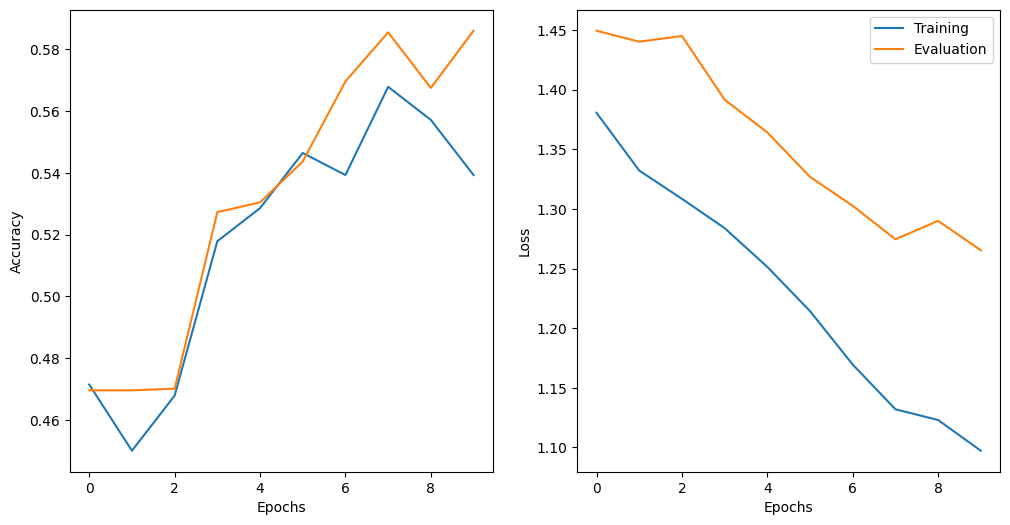

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)